# This is a Jupyter Notebook for a Customer Churn Prediction Model Using XGBoost Classification

The dataset used is:
https://github.com/navdeep-G/customer-churn/blob/master/data/TelcoChurn.csv
The model is trained using XGBoost and is tuned using hyperparameter tuning using GridSearchCV

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import compute_class_weight

In [2]:
#Load data
data = pd.read_csv("TelcoChurn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
print(data.info())
print(f"\n")
print(data.isnull().sum())
print(f"\n")
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


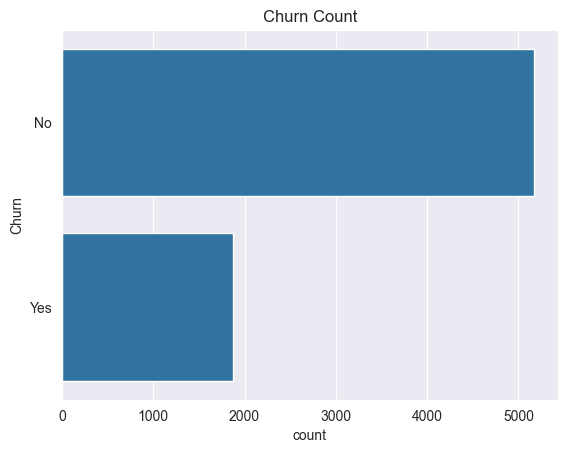

In [4]:
#Visualising the data
sns.countplot(data['Churn'])
plt.title("Churn Count")
plt.show()

In [5]:
#Data Preprocessing
#Clean data
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.drop(['customerID'], axis=1, inplace=True)


In [6]:
#Encoding categorical features
#Encoding binary columns (Yes/No)
# MAP ONLY IF NOT ALREADY MAPPED, RUN ONLY ONCE
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'PaperlessBilling', 'TechSupport', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'Churn']
for col in binary_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0})
print(f"{'Churn'} unique values after mapping: {data['Churn'].unique()}")
print(f"Any NaNs? {data['Churn'].isna().sum()}")

#One-Hot Encoding columns with non-binary column types.
data = pd.get_dummies(data, drop_first=True)


Churn unique values after mapping: [0 1]
Any NaNs? 0


In [7]:
print(data.head())

   SeniorCitizen  Partner  Dependents  tenure  PhoneService  OnlineSecurity  \
0              0        1           0       1             0             0.0   
1              0        0           0      34             1             1.0   
2              0        0           0       2             1             1.0   
3              0        0           0      45             0             1.0   
4              0        0           0       2             1             0.0   

   OnlineBackup  DeviceProtection  TechSupport  StreamingTV  ...  gender_Male  \
0           1.0               0.0          0.0          0.0  ...        False   
1           0.0               1.0          0.0          0.0  ...         True   
2           1.0               0.0          0.0          0.0  ...         True   
3           0.0               1.0          1.0          0.0  ...         True   
4           0.0               0.0          0.0          0.0  ...        False   

   MultipleLines_No phone service  Mul

In [8]:
#declaring features and label and then train-test splitting
X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Class Weights: {np.int64(0): np.float64(0.680763653939101), np.int64(1): np.float64(1.8830213903743316)}
Fitting 5 folds for each of 72 candidates, totalling 360 fits


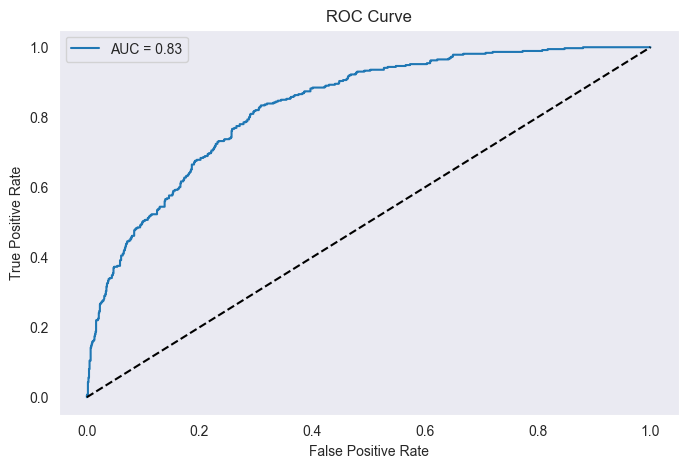

In [9]:
#calculate class weights for imbalance
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), weights))
print("Class Weights:", weight_dict)

#hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

#initializing base XGBoost model with scale_pos_weight
xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=weight_dict[0] / weight_dict[1],
    random_state=42
)

#grid search setuo
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='f1', cv=5, verbose=1, n_jobs=-1)

#fitting to data
grid_search.fit(X_train, y_train)

#best model
best_model = grid_search.best_estimator_

#predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1036
           1       0.70      0.39      0.50       373

    accuracy                           0.79      1409
   macro avg       0.75      0.67      0.69      1409
weighted avg       0.78      0.79      0.77      1409

Accuracy: 0.794180269694819
Confusion Matrix:  [[973  63]
 [227 146]]
ROC-AUC Score: 0.8323


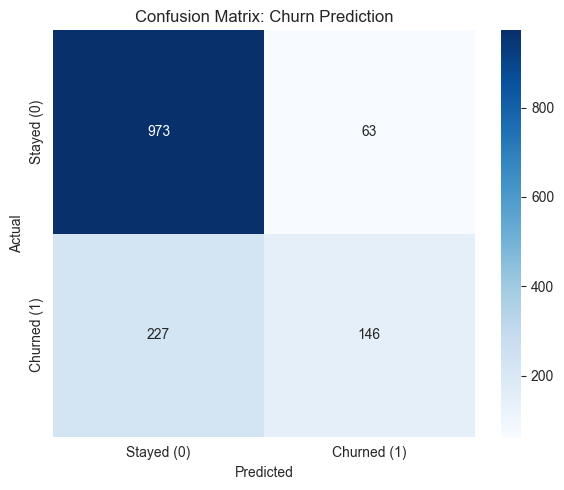

In [10]:
#visualising using heatmap
cm = confusion_matrix(y_test, y_pred)
labels = ['Stayed (0)', 'Churned (1)']

print("Classification Report")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix: ", confusion_matrix(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Churn Prediction')
plt.tight_layout()
plt.show()

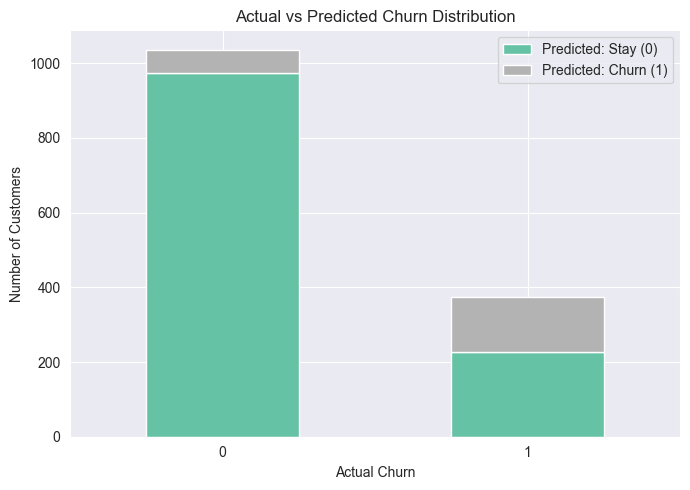

In [11]:
#using barplot
# DataFrame for bar plot
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Count combinations
counts = results_df.groupby(['Actual', 'Predicted']).size().unstack().fillna(0)

# Bar plot
counts.plot(kind='bar', stacked=True, colormap='Set2', figsize=(7, 5))
plt.title('Actual vs Predicted Churn Distribution')
plt.xlabel('Actual Churn')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.legend(['Predicted: Stay (0)', 'Predicted: Churn (1)'])
plt.tight_layout()
plt.show()
